In [1]:
# @title Install dependencies
!pip install opencv-python==4.1.2.30 --quiet
!pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 831.4 MB 2.3 kB/s eta 0:00:013     |█████▉                          | 152.5 MB 30.9 MB/s eta 0:00:22     |██████                          | 157.0 MB 30.9 MB/s eta 0:00:22     |██████                          | 158.3 MB 30.9 MB/s eta 0:00:22     |██████▎                         | 162.2 MB 30.9 MB/s eta 0:00:22     |█████████████████               | 441.1 MB 28.8 MB/s eta 0:00:14     |█████████████████▎              | 447.8 MB 28.8 MB/s eta 0:00:14     |█████████████████▍              | 451.8 MB 28.8 MB/s eta 0:00:14     |███████████████████             | 495.6 MB 22.5 MB/s eta 0:00:15     |█████████████████████▋          | 562.1 MB 31.7 MB/s eta 0:00:09     |█████████████████████▉          | 566.0 MB 31.7 MB/s eta 0:00:09     |██████████████████████          | 568.8 MB 31.7 MB/s eta 0:00:09     |██████████████████████▍         | 580.8 MB 36.6 MB/s eta 0:00:07     |███████████████

In [2]:
# Imports
import os
import cv2
import tqdm
import hashlib
import requests

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from numba import jit

from scipy.ndimage import gaussian_filter
from scipy.ndimage import find_objects, binary_fill_holes
from scipy.ndimage import generate_binary_structure, label
from scipy.optimize import linear_sum_assignment

# Our import functions
import glob
import matplotlib.image as mpimg
from pathlib import Path

In [77]:
original_images=np.load('/kaggle/input/hippocampus-segmentation/images_with_blanks.npy')
label_images=np.load('/kaggle/input/hippocampus-segmentation/labels_with_blanks.npy')
original_images.shape, label_images.shape

((4130, 197, 197), (4130, 197, 197))

In [78]:
# Split dataset into train and test set
from sklearn.model_selection import train_test_split

label_images_abs = np.max(label_images,axis=(1,2))

images_train, images_test, label_train, label_test = train_test_split(original_images, label_images, 
                                                    test_size=0.2, random_state=42, stratify=label_images_abs)

label_train_abs = np.max(label_train,axis=(1,2))
images_train, images_val, label_train, label_val = train_test_split(images_train, label_train, 
                                                    test_size=0.2, random_state=42, stratify=label_train_abs)

images_train = np.expand_dims(images_train, axis=1)
images_val = np.expand_dims(images_val, axis=1)
images_test = np.expand_dims(images_test, axis=1)

label_train = np.expand_dims(label_train, axis=1)
label_val = np.expand_dims(label_val, axis=1)
label_test = np.expand_dims(label_test, axis=1)

In [79]:
# Normalize images (zero mean, std=1)
mean_train = np.mean(images_train)
std_train = np.std(images_train)

images_train = (images_train - mean_train) / std_train
images_val = (images_val - mean_train) / std_train
images_test = (images_test - mean_train) / std_train

In [80]:
def resize(X,xy=(200, 200)):
    reshape_im = []
    for n in range(X.shape[0]):
        reshape_im.append(cv2.resize(X[n,0],xy))
    reshape_im = np.array(reshape_im)
    reshape_im = np.array(np.expand_dims(reshape_im,axis=1))
    return reshape_im

In [81]:
# GAN functions

norm_layer = nn.InstanceNorm2d
class ResBlock(nn.Module):
    def __init__(self, f):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(f, f, 3, 1, 1), norm_layer(f), nn.ReLU(),
                                  nn.Conv2d(f, f, 3, 1, 1))
        self.norm = norm_layer(f)
    def forward(self, x):
        return F.relu(self.norm(self.conv(x)+x))

class Generator(nn.Module):
    def __init__(self, f=64, blocks=9):
        super(Generator, self).__init__()
        layers = [nn.ReflectionPad2d(3),
                  nn.Conv2d(  3,   f, 7, 1, 0), norm_layer(  f), nn.ReLU(True),
                  nn.Conv2d(  f, 2*f, 3, 2, 1), norm_layer(2*f), nn.ReLU(True),
                  nn.Conv2d(2*f, 4*f, 3, 2, 1), norm_layer(4*f), nn.ReLU(True)]
        for i in range(int(blocks)):
            layers.append(ResBlock(4*f))
        layers.extend([
                nn.ConvTranspose2d(4*f, 4*2*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(2*f), nn.ReLU(True),
                nn.ConvTranspose2d(2*f,   4*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(  f), nn.ReLU(True),
                nn.ReflectionPad2d(3), nn.Conv2d(f, 3, 7, 1, 0),
                nn.Tanh()])
        self.conv = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.conv(x)

nc=3
ndf=64
class Discriminator(nn.Module):  
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc,ndf,4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf,ndf*2,4,2,1, bias=False),
            nn.InstanceNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf*4,ndf*8,4,1,1),
            nn.InstanceNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 15 x 15
            nn.Conv2d(ndf*8,1,4,1,1)
            # state size. 1 x 14 x 14
        )

    def forward(self, input):
        return self.main(input)
    
    
    
def LSGAN_D(real, fake):
  return (torch.mean((real - 1)**2) + torch.mean(fake**2))

def LSGAN_G(fake):
  return  torch.mean((fake - 1)**2)


save_path = '/kaggle/working/'
model_path = '/kaggle/input/cyclegan-model/'
def save_models(G_A2B, G_B2A, D_A, D_B, name):

  torch.save(G_A2B, save_path+name+"_G_A2B.pt")
  torch.save(G_B2A, save_path+name+"_G_B2A.pt")
  torch.save(D_A, save_path+name+"_D_A.pt")
  torch.save(D_B, save_path+name+"_D_B.pt")

def load_models( name):

  G_A2B=torch.load(model_path+name+"_G_A2B.pt")
  G_B2A=torch.load(model_path+name+"_G_B2A.pt")
  D_A=torch.load(model_path+name+"_D_A.pt")
  D_B=torch.load(model_path+name+"_D_B.pt")
  return G_A2B, G_B2A, D_A, D_B

#save_models(G_A2B, G_B2A, D_A, D_B, "test")
#G_A2B, G_B2A, D_A, D_B= load_models("test")

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [82]:
# U-net functions

def convbatchrelu(in_channels, out_channels, sz):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, sz, padding=sz//2),
      nn.BatchNorm2d(out_channels, eps=1e-5),
      nn.ReLU(inplace=True),
      )


class convdown(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.conv = nn.Sequential()
    for t in range(2):
      if t == 0:
        self.conv.add_module('conv_%d'%t,
                             convbatchrelu(in_channels,
                                           out_channels,
                                           kernel_size))
      else:
        self.conv.add_module('conv_%d'%t,
                             convbatchrelu(out_channels,
                                           out_channels,
                                           kernel_size))

  def forward(self, x):
    x = self.conv[0](x)
    x = self.conv[1](x)
    return x


class downsample(nn.Module):
  def __init__(self, nbase, kernel_size):
    super().__init__()
    self.down = nn.Sequential()
    self.maxpool = nn.MaxPool2d(2, 2)
    for n in range(len(nbase) - 1):
      self.down.add_module('conv_down_%d'%n,
                           convdown(nbase[n],
                                    nbase[n + 1],
                                    kernel_size))

  def forward(self, x):
    xd = []
    for n in range(len(self.down)):
      if n > 0:
        y = self.maxpool(xd[n - 1])
      else:
        y = x
      xd.append(self.down[n](y))
    return xd


class convup(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.conv = nn.Sequential()
    self.conv.add_module('conv_0', convbatchrelu(in_channels,
                                                 out_channels,
                                                 kernel_size))
    self.conv.add_module('conv_1', convbatchrelu(out_channels,
                                                 out_channels,
                                                 kernel_size))

  def forward(self, x, y):
    #print(x.shape, y.shape)
    x = self.conv[0](x)
    x = self.conv[1](x + y)
    return x


class upsample(nn.Module):
  def __init__(self, nbase, kernel_size):
    super().__init__()
    self.upsampling = nn.Upsample(scale_factor=2, mode='nearest')
    self.up = nn.Sequential()
    for n in range(len(nbase) - 1 , 0, -1):
      self.up.add_module('conv_up_%d'%(n - 1),
              convup(nbase[n], nbase[n - 1], kernel_size))

  def forward(self, xd):
    x = xd[-1]
    for n in range(0, len(self.up)):
      if n > 0:
        x = self.upsampling(x)
      x = self.up[n](x, xd[len(xd) - 1 - n])
    return x


class Unet(nn.Module):
  def __init__(self, nbase, nout, kernel_size):
    super(Unet, self).__init__()
    self.nbase = nbase
    self.nout = nout
    self.kernel_size = kernel_size
    self.downsample = downsample(nbase, kernel_size)
    nbaseup = nbase[1:]
    nbaseup.append(nbase[-1])
    self.upsample = upsample(nbaseup, kernel_size)
    self.output = nn.Conv2d(nbase[1], self.nout, kernel_size,
                            padding=kernel_size//2)

  def forward(self, data):
    T0 = self.downsample(data)
    T0 = self.upsample(T0)
    T0 = self.output(T0)
    return T0

  def save_model(self, filename):
    torch.save(self.state_dict(), filename)

  def load_model(self, filename, cpu=False):
    if not cpu:
      self.load_state_dict(torch.load(filename))
    else:
      self.__init__(self.nbase,
                    self.nout,
                    self.kernel_size,
                    self.concatenation)

      self.load_state_dict(torch.load(filename,
                                      map_location=torch.device('cpu')))

In [83]:
# Create a new instance of U-net to train

kernel_size = 3
nbase = [1, 32, 64, 128, 256]  # number of channels per layer
nout = 2  # number of outputs

net = Unet(nbase, nout, kernel_size)
# put on GPU here if you have it
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net.to(device);  # remove semi-colon to see net structure

In [130]:
# Load the cycleGAN

name="MRIcycleGAN2"
G_A2B, G_B2A, D_A, D_B = load_models(name)

def ganify(image_batch,xy=(200,200)):
    image_batch = resize(image_batch,xy=xy)
    image_batch = torch.tensor(image_batch).type(torch.float32).expand(image_batch.shape[0],3,xy[0],xy[1]).cuda()
    image_batch_trans = G_A2B(image_batch)
    return image_batch_trans

In [131]:
# U-net training loop

from datetime import datetime

# parameters related to training the network
batch_size = 8 # number of images per batch -- amount of required memory
              # for training will increase linearly in batchsize
n_epochs = 50  # number of times to cycle through all the data during training
learning_rate = 0.1 # initial learning rate
weight_decay = 1e-5 # L2 regularization of weights
momentum = 0.9 # how much to use previous gradient direction
n_epochs_per_save = 25 # how often to save the network
val_frac = 0.05 # what fraction of data to use for validation
augmentation = True


now = datetime.now()
timestamp = now.strftime('%Y%m%dT%H%M%S')

n_train = images_train.shape[0]
n_val = images_val.shape[0]

# gradient descent flavor
optimizer = torch.optim.SGD(net.parameters(),
                            lr=learning_rate,
                            weight_decay=weight_decay,
                            momentum=0.9)

# set learning rate schedule
LR = np.linspace(0, learning_rate, 10)
if n_epochs > 250:
    LR = np.append(LR, learning_rate*np.ones(n_epochs-100))
    for i in range(10):
        LR = np.append(LR, LR[-1]/2 * np.ones(10))
else:
    LR = np.append(LR, learning_rate * np.ones(max(0, n_epochs - 10)))

criterion = nn.CrossEntropyLoss()

# store loss per epoch
epoch_losses = np.zeros(n_epochs)
epoch_losses[:] = np.nan
val_losses = np.zeros(n_epochs)
val_losses[:] = np.nan

# when we last saved the network
saveepoch = None

# loop through entire training data set nepochs times
for epoch in range(n_epochs):
  epoch_loss = 0
  val_loss=0
  iters = 0
  for param_group in optimizer.param_groups:
    param_group['lr'] = LR[epoch]
  with tqdm.tqdm(total=n_train, desc=f"Epoch {epoch + 1}/{n_epochs}", unit='img') as pbar:
    # loop through each batch in the training data
    net.train() # put in train mode (affects batchnorm)
    for ibatch in np.arange(0, n_train, batch_size):
      # augment the data
      inds = np.arange(ibatch, min(n_train, ibatch+batch_size))

      if (augmentation == True) and (np.random.random() < 0.5):
        imgs = ganify(images_train[inds],xy=(200,200))
        imgs = imgs[:,0:1,:,:]
        lbls = resize(label_train[inds].astype(float),xy = (200,200)).astype(int)
        lbls = torch.from_numpy(lbls)
        
      else:
        imgs = resize(images_train[inds],xy = (200,200))
        lbls = resize(label_train[inds].astype(float),xy = (200,200)).astype(int)
        imgs = torch.from_numpy(imgs)
        lbls = torch.from_numpy(lbls)

      imgs = imgs.to(device=device)
      lbls = lbls.to(device=device)
        
      imgs = imgs.to(dtype=torch.float32)
      lbls = lbls.to(dtype=torch.int64)

      # compute the loss
      y = net(imgs)
      loss = criterion(y, lbls[:, 0])
      epoch_loss += loss.item()
      pbar.set_postfix(**{'loss (batch)': loss.item()})
      # gradient descent
      optimizer.zero_grad()
      loss.backward()
      #nn.utils.clip_grad_value_(net.parameters(), 0.1)
      optimizer.step()
      iters+=1
      pbar.update(imgs.shape[0])

    net.eval()  

    for ibatch in np.arange(0,n_val,batch_size):
      inds = np.arange(ibatch, min(n_val, ibatch+batch_size))

      imgs_val = resize(images_val[inds],xy = (200,200))
      lbls_val = resize(label_val[inds].astype(float),xy = (200,200)).astype(int)
      imgs_val = torch.from_numpy(imgs_val).to(device=device)
      lbls_val = torch.from_numpy(lbls_val).to(device=device)
      imgs_val = imgs_val.to(dtype=torch.float32)
      lbls_val = lbls_val.to(dtype=torch.int64)  
      output = net(imgs_val)
      loss = criterion(output,lbls_val[:, 0])
      val_loss+=loss.item()
      pbar.set_postfix(**{'val (batch)': loss.item()})

  # Setting up mean loss: n_val/batch_size= total number of batches
    epoch_losses[epoch] = epoch_loss/(n_train/batch_size)
    val_losses[epoch] = val_loss/(n_val/batch_size)
    
    
    pbar.set_postfix(**{'loss (epoch)': epoch_loss,'Val (epoch)': val_loss})  #.update('loss (epoch) = %f'%epoch_loss)

  # save checkpoint networks every now and then
  if epoch % n_epochs_per_save == 0:
    print(f"\nSaving network state at epoch {epoch+1}")
    saveepoch = epoch
    savefile = f"unet_epoch_augGAN_{saveepoch+1}.pth"
    net.save_model(savefile)
print(f"\nSaving network state at epoch {epoch+1}")
if augmentation:
    fname = 'unet_epoch_'+str(epoch+1)+'_augGAN.pth'
    np.save('augGAN_epoch_loss',epoch_losses)
    np.save('augGAN_val_losses',val_losses)
else:
    fname = 'unet_epoch_'+str(epoch+1)+'_no_augmentation.pth'
    np.save('no_augmentation_epoch_loss',epoch_losses)
    np.save('no_augmentation_val_losses',val_losses)    
net.save_model(fname)

Epoch 2/50:   0%|          | 0/2643 [00:00<?, ?img/s, loss (batch)=0.0216]


Saving network state at epoch 1


Epoch 27/50:   0%|          | 8/2643 [00:00<00:38, 67.68img/s, loss (batch)=0.00228]


Saving network state at epoch 26


Epoch 50/50: 100%|██████████| 2643/2643 [00:56<00:00, 46.94img/s, Val (epoch)=0.986, loss (epoch)=0.41]



Saving network state at epoch 50


In [135]:
val_losses.shape

(50,)

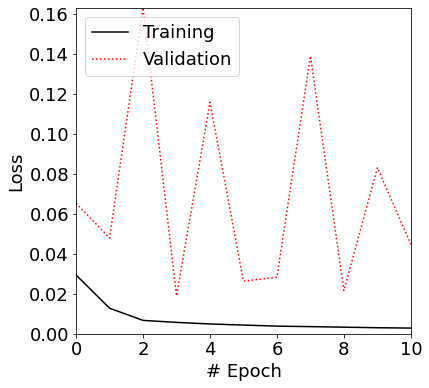

In [133]:
plt.rcParams.update({'font.size': 18})

def plot_loss(epoch_losses, val_losses):
    fig = plt.figure(figsize=(6,6))
    plt.plot(epoch_losses,'black',label='Training')
    plt.plot(val_losses,color='r',linestyle=':',label='Validation')
    plt.xlabel('# Epoch')
    plt.ylabel('Loss')
    plt.ylim([0,np.max([epoch_losses, val_losses])])
    plt.xlim([0,10])
    plt.legend()
    
plot_loss(epoch_losses,val_losses)

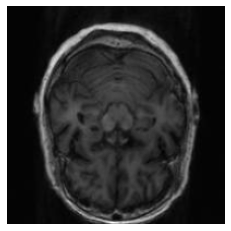

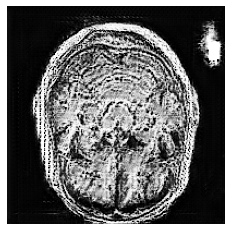

<Figure size 432x288 with 0 Axes>

In [145]:
im = torch.tensor(resize(images_test[0:2])).type(torch.float32)
im = im.expand(2,3,200,200).cuda()

p = im[1,0].detach().cpu()
plt.imshow(p,cmap='gray')
plt.axis('off')
plt.show()
plt.savefig('GAN_example_in.png', dpi=600,bbox_inches='tight')

im_gen = G_A2B(im).detach().cpu()
plt.imshow(im_gen[1,0],cmap='gray',vmin=0)
plt.axis('off')
plt.show()
plt.savefig('GAN_example_out.png', dpi=600,bbox_inches='tight')

(-0.5, 196.5, 196.5, -0.5)

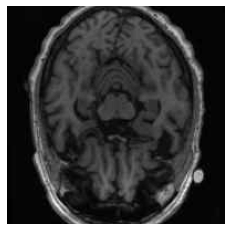

In [146]:
n=0
plt.imshow(label_test[n,0],cmap='gray')
plt.axis('off')
#plt.savefig('Example_seg.png', dpi=600,bbox_inches='tight')

plt.imshow(images_test[n,0],cmap='gray')
plt.axis('off')
#plt.savefig('Example_im.png', dpi=600,bbox_inches='tight')

torch.Size([826, 1, 200, 200])


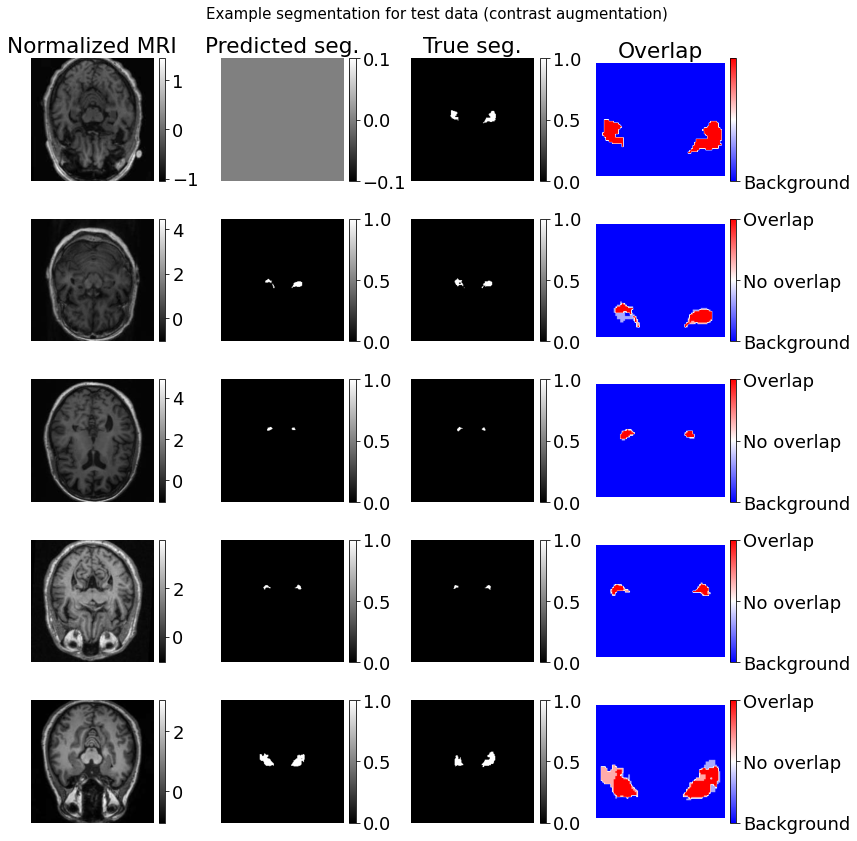

In [148]:
n = 5;
image = resize(images_test)
label = resize(label_test.astype(float)).astype(int)
net.eval()
img_torch = torch.tensor(image).to(device)
img_torch = img_torch.to(torch.float32)
print(img_torch.shape)
out = net(img_torch[0:n])



from matplotlib import gridspec
color_code = '#0699C8'#'#e377c2'
color_code = '#006666'#'#e377c2'
legend_pos = 'lower left'
fig = plt.figure(figsize=(12,12))
nrows=5;
ncols=4;
gs = gridspec.GridSpec(nrows, ncols,figure=fig)
# gs.update(wspace=0.6, hspace=0.3) # set the spacing between axes. 

for rowIndx in range(nrows):
    prediction = np.array(out[rowIndx].detach().cpu())
    seg = np.argmax(prediction,axis=0)
    for cIndx in range(ncols):
        ax = fig.add_subplot(gs[rowIndx, cIndx]) 
        ax.axis('off')
        if cIndx == 0:
            plt.imshow(image[rowIndx][0],cmap='gray')
            plt.colorbar(fraction=0.046, pad=0.04)
            if rowIndx == 0:
                plt.title('Normalized MRI')
        if cIndx == 1: 
            plt.imshow(seg, cmap = 'gray')
            plt.colorbar(fraction=0.046, pad=0.04)
            if rowIndx == 0:
                plt.title('Predicted seg.')
        if cIndx == 2: 
            plt.imshow(label[rowIndx][0], cmap = 'gray')
            plt.colorbar(fraction=0.046, pad=0.04)
            if rowIndx == 0:
                plt.title('True seg.')  
        temp = label[rowIndx][0] +  2*seg        
        if cIndx == 3: 
            plt.imshow(temp[50:-80,60:-60], cmap = 'bwr')
            cbar = plt.colorbar(fraction=0.046, pad=0.04,ticks=[0, 1.5, 3])
            cbar.ax.set_yticklabels(['Background','No overlap','Overlap'],rotation=0)
            if rowIndx == 0:
                plt.title('Overlap')                   
plt.rc('font', family='sans-serif', serif='Helvetica')
plt.suptitle('Example segmentation for test data (contrast augmentation)', fontsize = 15)
plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.savefig('Example_with_contrast_aug.png', dpi=600,bbox_inches='tight')

In [149]:
# Test network performance & plot performance metrics
# https://scikit-learn.org/stable/modules/classes.html?highlight=metric#module-sklearn.metrics
from sklearn.metrics import precision_score, accuracy_score, f1_score

def compute_metrics(all_labels, all_segs): 
    new_label = np.squeeze(all_labels)
    new_segs = np.squeeze(all_segs)
    p = []
    f = []
    n = new_label.shape[0]
    # temp = 1*np.where(new_segs[0].flatten()==0)[0]
    # print(new_label[0].flatten().dtype)
    for imgIndx in range(n):
        precision = precision_score(new_label[imgIndx].flatten(), new_segs[imgIndx].flatten())
        f_score = f1_score(new_label[imgIndx].flatten(), new_segs[imgIndx].flatten())
        if (np.max(new_label[imgIndx])==0) & (np.max(new_segs[imgIndx])==0):
          p.append(1.0)
          f.append(1.0)
        else:
          p.append(precision)
          f.append(f_score)
        # p.append( precision_score(new_label[imgIndx].flatten(), new_segs[imgIndx].flatten()) )
        # f.append( f1_score(new_label[imgIndx].flatten(), new_segs[imgIndx].flatten()) )
        # p.append( precision_score(new_label[imgIndx].flatten(), new_segs[imgIndx].flatten()==0) )
        # f.append( f1_score(new_label[imgIndx].flatten(), new_segs[imgIndx].flatten()==0) )        
    return p, f

In [150]:
import time
start = time.time()
net.eval()
image = resize(images_test)
label = resize(label_test.astype(float)).astype(int)
batch_size = 16
seg = np.empty((label.shape[0], label.shape[2],label.shape[3]));              # initialize the predictions
n_test = images_test.shape[0]
for ibatch in np.arange(0,n_test,batch_size):
    inds = np.arange(ibatch, min(n_test, ibatch+batch_size))
    img_torch = torch.tensor(image[inds]).to(device)
    img_torch = img_torch.to(torch.float32)
    lbls_torch = torch.tensor(label[inds]).to(device)
    #     lbls_torch = lbls_torch.to(torch.int64)
    out = net(img_torch)
    out = np.array((out.detach()).to('cpu'))
    

    out = np.argmax(out,axis=1)
#     print(out.shape)
#     seg[inds][:][:][:] = np.expand_dims(out, 1)      #I don't know hwy this does not work..
    seg[inds] = out 
#     #     print(np.expand_dims(out, 1).shape)
seg = np.expand_dims(seg, 1)
end = time.time()
print(end - start)

3.4319145679473877


In [151]:
resize_label_test = resize(label_test.astype(float)).astype(int)
p, f = compute_metrics(np.squeeze(resize_label_test), seg)

print('Mean of p: ', np.mean(p) )
print('Median of p: ', np.median(p) )
print('STD of p: ', np.std(p) )
print('Mean of F1: ', np.mean(f) )
print('Median of F1: ', np.median(f) )
print('STD of F1: ', np.std(f) )

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Mean of p:  0.7227251636819507
Median of p:  0.8183014354066986
STD of p:  0.27974148905745794
Mean of F1:  0.6796909049555875
Median of F1:  0.7977166276346603
STD of F1:  0.2846807027884973


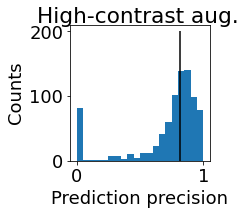

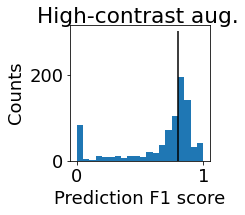

In [152]:
# plot precision and F1 score
plt.figure(figsize=(2.5,2.5))
plt.hist(p,20)
plt.vlines(np.median(p),0,200,color='black')
plt.xlabel('Prediction precision')
plt.ylabel('Counts')
plt.suptitle('High-contrast aug.')

plt.savefig('Highcontrast_aug_precision.png', dpi=600,bbox_inches='tight')

plt.figure(figsize=(2.5,2.5))
plt.hist(f,20)
plt.vlines(np.median(f),0,300,color='black')
plt.xlabel('Prediction F1 score')
plt.ylabel('Counts')
plt.suptitle('High-contrast aug.')

plt.savefig('Highcontrast_aug_f1.png', dpi=600,bbox_inches='tight')